# FX Carry Trade Project NEW
Fx carry is a tried and tested staple of FX strategies. It involves borrowing in a low interest rate currency and investing in a high interest rate currency. You profit from what is called the "interest rate differential". So all we need to do is find a pair of currencies with historically different rates. This project will simulate this strategy over time. I obtain/approximate short-term interest rates for the the two currencies and the historical FX rates. Then, I calculate the daily/monthly returns which is simply the interest earned from the diffrential plus any gain/loss from currency movements. I then compare this strategy to a simple buy-and-hold of the currencies to illustrate its risk/return profile.

This project itself is rather simple, but I mainly chose this project to "quantify" my experience at LSE trading society's Emerging Markets subcommittee. Although the currencies here are not from emerging economies, most of my strategies in the subcommittee involved FX trades, which is what I build on here. Specifically, I modify a simple carry strategy to include a volatility target.

* I downloaded fx csv data from FRED (5 year time frame, daily data)
* I downloaded rates csv data from BIS (5 year time frame, monthly data)

#### First I start off the basic imports:

In [431]:
import os
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Parameters and Paths:

In [432]:
top_n = 2             # no of currencies long
bottom_n = 2             #no of currencies short
trans_cost = 1.0           #transaction cost per unit turnover measured in bps

target_vol = 0.3         # annualized target portfolio vol
vol_window = 60            # rolling window days for realised vol
lev_min = 0.2           # leverage floor
lev_max = 2.0           # leverage cap

fx_path = "data/fx.csv"    #wide daily levels for various currencies
rates_path = "data/rates.csv"  #monthly policy rates for various currencies
out_dir = "output"
os.makedirs("data", exist_ok=True)
os.makedirs(out_dir, exist_ok=True)

#here is the usd data need later
usd_code = "USD"
usd_bis_file = f"bis_{usd_code}.csv"

#### Build DataFrames from the FRED and BIS CSVs:
#### Firstly for FRED:
Because some of the FX data is swapped, we want to swap them to have them all in form USD per XXX. It simply makes it easier to code with one "master currence" that the others are quoted in terms of.
The folder layout on GitHub for reference is:
- ..data/
- ....fred/
- ......DEXUSEU.csv
- ......DEXUSUK.csv
- ......etc
- ....bis/
- ......bis_EUR.scv
- ......bis_GBP.csv
- ......etc

Our outputs will be
- `fx` which is daily FX levels (with columns `EURUSD`, `GBPUSD`, etc)
- `rates_m` which is monthly polciy rates (columns are `EUR, GBP, ...`)
- `rates_d` which is daily policy rates aligned to `fx`'s index and columns which just makes the data set clearer

In [433]:
fred_dir = "data/fred"
bis_dir = "data/bis"

#FRED FX mapping: final column name maps to a tuple filename,invert needed where invert_needed=True means we need to inver from XXXYYY to YYYXXX
fred_map = {
    "EURUSD": ("DEXUSEU.csv", False),  # USD per EUR
    "GBPUSD": ("DEXUSUK.csv", False),  # USD per GBP
    "AUDUSD": ("DEXUSAL.csv", False),  # USD per AUD
    "NZDUSD": ("DEXUSNZ.csv", False),  # USD per NZD
    "JPYUSD": ("DEXJPUS.csv", True),   # JPY per USD 
    "CHFUSD": ("DEXSZUS.csv", True),   # CHF per USD 
    "CADUSD": ("DEXCAUS.csv", True),   # CAD per USD 
    "NOKUSD": ("DEXNOUS.csv", True),   # NOK per USD 
    "SEKUSD": ("DEXSDUS.csv", True),   # SEK per USD
}

I had a lot of issues with the following function, so i added a few warning strings:

In [434]:
def read_fred(path, out_col, invert):
    #If we cant find the path, we return this error below
    if not os.path.exists(path):
        print(f"[FRED] missing {os.path.basename(path)} => skip {out_col}")
        return None
        
    df = pd.read_csv(path, na_values=["."])

    #If we cant find the observation_date column, we return this error 
    #I could manually check all the CSVs for this column, but for larger data sets this is simply unfeasible
    if "observation_date" not in df.columns:
        raise ValueError(f"{os.path.basename(path)} has no 'observation_date' column. Got: {list(df.columns)}")

    # normalise headers (trim spaces, keep original case where helpful)
    df.columns = [str(c).strip() for c in df.columns]

    # take the first non date column as the series
    value_cols = [c for c in df.columns if c != "observation_date"]
    if not value_cols:
        raise ValueError(f"No value column found in {os.path.basename(path)}")
    val_col = value_cols[0]

    # parse and clean
    df["observation_date"] = pd.to_datetime(df["observation_date"], errors="coerce")
    df[val_col] = pd.to_numeric(df[val_col], errors="coerce")

    df = (df.dropna(subset=["observation_date"]).sort_values("observation_date")
        .set_index("observation_date").rename(columns={val_col: out_col}))

    if invert:
        df[out_col] = 1.0 / df[out_col].replace(0, np.nan)

    return df[[out_col]]

In [435]:
read_fred(os.path.join(fred_dir, "DEXUSEU.csv"), "EURUSD", False)

,EURUSD
observation_date,
2020-08-24,1.1803
2020-08-25,1.1818
2020-08-26,1.1813
2020-08-27,1.1824
2020-08-28,1.1901
...,...
2025-08-18,1.1667
2025-08-19,1.1660
2025-08-20,1.1649


In [436]:
# Now we build the data frame for FRED, ie we just stitch togther all the individual columns above in a loop
frames = []  #we start the list that will contain each single series dataframe, ie one per currency pair
    
for col, (fname, inv) in fred_map.items():
    f = read_fred(os.path.join(fred_dir, fname), col, inv)  #builds the full file path (folder + file name) and calls our `read_fred()`
        
    if f is not None:
        frames.append(f)
            
if not frames:
    raise FileNotFoundError("No FRED series found under data/fred/.")
        
#Next we stitch all these 1-column data frames side by side into a single table, aligning them by dates  
#ffill() forward fills missing values, as FRED has gaps (it uses previous value for blanks)
fx = pd.concat(frames, axis=1).sort_index().ffill()  
fx.index.name = "date"
    
# keep columns in our order defined in `fred_map`
fx = fx[[c for c in fred_map if c in fx.columns]] 
fx

,EURUSD,GBPUSD,AUDUSD,NZDUSD,JPYUSD,CHFUSD,CADUSD,NOKUSD,SEKUSD
date,,,,,,,,,
2020-08-24,1.1803,1.3078,0.7174,0.6536,0.009443,1.097815,0.756430,0.111169,0.113871
2020-08-25,1.1818,1.3136,0.7180,0.6530,0.009398,1.100231,0.758093,0.111414,0.113998
2020-08-26,1.1813,1.3186,0.7222,0.6600,0.009422,1.100594,0.760746,0.112106,0.114431
2020-08-27,1.1824,1.3229,0.7260,0.6641,0.009397,1.101686,0.762718,0.112514,0.114812
2020-08-28,1.1901,1.3341,0.7352,0.6741,0.009497,1.106072,0.763009,0.113792,0.115915
...,...,...,...,...,...,...,...,...,...
2025-08-18,1.1667,1.3521,0.6494,0.5925,0.006768,1.239465,0.723851,0.098031,0.104665
2025-08-19,1.1660,1.3496,0.6459,0.5901,0.006770,1.239157,0.721553,0.097349,0.104300
2025-08-20,1.1649,1.3450,0.6428,0.5822,0.006794,1.243163,0.720773,0.097667,0.104251


#### Now for BIS:
We build the monthly policy rates `rates_m` dataframe from the bis csvs. The rates are all quoted as percentages in the CSVs. And the date is quoted as DD-MM-YYYY under the `Period` column in the CSVs.

Much like the FRED code above, we stitch together the individual columns. The only difference with bis was that the CSV tables have the columns starting at row 4 instead of row 1, so I had to account for this below. This is done very simply by using the `skiprows` argument for `pd.read_csv`

In [437]:
pd.read_csv?

Signature:
pd.read_csv(
    filepath_or_buffer: 'FilePath | ReadCsvBuffer[bytes] | ReadCsvBuffer[str]',
    *,
    sep: 'str | None | lib.NoDefault' = <no_default>,
    delimiter: 'str | None | lib.NoDefault' = None,
    header: "int | Sequence[int] | None | Literal['infer']" = 'infer',
    names: 'Sequence[Hashable] | None | lib.NoDefault' = <no_default>,
    index_col: 'IndexLabel | Literal[False] | None' = None,
    usecols: 'UsecolsArgType' = None,
    dtype: 'DtypeArg | None' = None,
    engine: 'CSVEngine | None' = None,
    converters: 'Mapping[Hashable, Callable] | None' = None,
    true_values: 'list | None' = None,
    false_values: 'list | None' = None,
    skipinitialspace: 'bool' = False,
    skiprows: 'list[int] | int | Callable[[Hashable], bool] | None' = None,
    skipfooter: 'int' = 0,
    nrows: 'int | None' = None,
    na_values: 'Hashable | Iterable[Hashable] | Mapping[Hashable, Iterable[Hashable]] | None' = None,
    keep_default_na: 'bool' = True,
    na_filter: '

In [438]:
bis_dir = "data/bis"
currency_list = ["EUR","GBP","AUD","NZD","JPY","CHF","CAD","NOK","SEK"]  # ignore USD for XXXUSD pairs

rates_list = []

for currency in currency_list:
    path = os.path.join(bis_dir, f"bis_{currency}.csv")
    if not os.path.exists(path):
        print(f"[BIS] missing {path} (skip {currency})")
        continue
    
    #here we tell pandas to use the required columns and skip rows 1 thru 3
    df = pd.read_csv(path, usecols=["Period", "Value"], skiprows=3)  
    df["Period"] = pd.to_datetime(df["Period"], errors="coerce")
    df["Value"]  = pd.to_numeric(df["Value"], errors="coerce")

    #convert percentages to decimals
    df["Value"] = df["Value"] / 100.0

    # make a Series named by currency code
    s = df.set_index("Period")["Value"].rename(currency)
    rates_list.append(s)

#We now append USD to the last column
usd_path = os.path.join(bis_dir, "bis_USD.csv")
df_usd = pd.read_csv(usd_path, usecols=["Period", "Value"], skiprows=3)
df_usd["Period"] = pd.to_datetime(df_usd["Period"], errors="coerce")
df_usd["Value"]  = pd.to_numeric(df_usd["Value"], errors="coerce")
df_usd["Value"]  = df_usd["Value"] / 100.0  # convert to decimals
s_usd = df_usd.set_index("Period")["Value"].rename("USD")
rates_list.append(s_usd)

#  monthly table created last by using panda's concat
rates_m = pd.concat(rates_list, axis=1).sort_index() 

print("rates_m shape:", getattr(rates_m, "shape", None))
rates_m

rates_m shape: (59, 10)


,EUR,GBP,AUD,NZD,JPY,CHF,CAD,NOK,SEK,USD
Period,,,,,,,,,,
2020-09-30,0.0000,0.0010,0.0025,0.0025,-0.0010,-0.0075,0.0025,0.0000,0.0000,0.00125
2020-10-31,0.0000,0.0010,0.0025,0.0025,-0.0010,-0.0075,0.0025,0.0000,0.0000,0.00125
2020-11-30,0.0000,0.0010,0.0010,0.0025,-0.0010,-0.0075,0.0025,0.0000,0.0000,0.00125
2020-12-31,0.0000,0.0010,0.0010,0.0025,-0.0010,-0.0075,0.0025,0.0000,0.0000,0.00125
2021-01-31,0.0000,0.0010,0.0010,0.0025,-0.0010,-0.0075,0.0025,0.0000,0.0000,0.00125
2021-02-28,0.0000,0.0010,0.0010,0.0025,-0.0010,-0.0075,0.0025,0.0000,0.0000,0.00125
2021-03-31,0.0000,0.0010,0.0010,0.0025,-0.0010,-0.0075,0.0025,0.0000,0.0000,0.00125
2021-04-30,0.0000,0.0010,0.0010,0.0025,-0.0010,-0.0075,0.0025,0.0000,0.0000,0.00125
2021-05-31,0.0000,0.0010,0.0010,0.0025,-0.0010,-0.0075,0.0025,0.0000,0.0000,0.00125


#### Setting the backtest window and changing rates from monthly to daily
Next I turn the `rates_m` df from a monthly to a daily table. This needs to be done in order to align with the FX table, which of course records FX daily.

However, the FRED data starts at 24/08/2020 and ends 24/08/2025. The bis starts 30/09/2020 and ends 31/07/2025. We know the bis rate recorded at the end of a month is the rate for that whole month, so the 30/09/2020 rate starts at 01/09/2020. Thus we want rates_d (ie our daily rates) to start at 01/09/2020 and end at 30/07/2025. Eventhough this time span is just under 5 years, we can adjust following code to account for this.

In [439]:
start_date = pd.Timestamp("2020-09-01")
end_date = pd.Timestamp("2025-07-31")
fx = fx.loc[start_date:end_date].copy()
fx

,EURUSD,GBPUSD,AUDUSD,NZDUSD,JPYUSD,CHFUSD,CADUSD,NOKUSD,SEKUSD
date,,,,,,,,,
2020-09-01,1.1949,1.3416,0.7375,0.6766,0.009434,1.102293,0.766695,0.114312,0.115318
2020-09-02,1.1840,1.3315,0.7319,0.6757,0.009421,1.098056,0.765638,0.113019,0.114534
2020-09-03,1.1832,1.3263,0.7272,0.6707,0.009422,1.098418,0.761557,0.112041,0.114294
2020-09-04,1.1820,1.3230,0.7264,0.6702,0.009404,1.093255,0.763650,0.111732,0.114101
2020-09-07,1.1820,1.3230,0.7264,0.6702,0.009404,1.093255,0.763650,0.111732,0.114101
...,...,...,...,...,...,...,...,...,...
2025-07-25,1.1730,1.3429,0.6556,0.6006,0.006767,1.255493,0.729182,0.098280,0.104910
2025-07-28,1.1609,1.3393,0.6519,0.5973,0.006736,1.246106,0.728969,0.098231,0.104207
2025-07-29,1.1534,1.3339,0.6509,0.5955,0.006731,1.239004,0.725847,0.097873,0.103560


In [440]:
# we reindex to match our new fx indexes and then we back fill now instead of forward fill
rates_d = rates_m.reindex(fx.index).bfill().copy()

rates_d

,EUR,GBP,AUD,NZD,JPY,CHF,CAD,NOK,SEK,USD
date,,,,,,,,,,
2020-09-01,0.00,0.0010,0.0025,0.0025,-0.001,-0.0075,0.0025,0.0000,0.00,0.00125
2020-09-02,0.00,0.0010,0.0025,0.0025,-0.001,-0.0075,0.0025,0.0000,0.00,0.00125
2020-09-03,0.00,0.0010,0.0025,0.0025,-0.001,-0.0075,0.0025,0.0000,0.00,0.00125
2020-09-04,0.00,0.0010,0.0025,0.0025,-0.001,-0.0075,0.0025,0.0000,0.00,0.00125
2020-09-07,0.00,0.0010,0.0025,0.0025,-0.001,-0.0075,0.0025,0.0000,0.00,0.00125
...,...,...,...,...,...,...,...,...,...,...
2025-07-25,0.02,0.0425,0.0385,0.0325,0.005,0.0000,0.0275,0.0425,0.02,0.04375
2025-07-28,0.02,0.0425,0.0385,0.0325,0.005,0.0000,0.0275,0.0425,0.02,0.04375
2025-07-29,0.02,0.0425,0.0385,0.0325,0.005,0.0000,0.0275,0.0425,0.02,0.04375


#### Weights
Now we calculate carry scores and use them to calculate monthly top/bottom currencies. We then calculate daily weights, which we hold throughout the month. The tables `long_mask` and `short_mask` are boolean tables, with entries `True` where a currency policy rate is either in the highest 3 or the lowest 3, respectively. When converted to a float, `True` becomes `1.0` and `False` becomes `0.0`.

Note that when you sum along a row, the weights all sum to 0. This ensures our position is neutral (ie longs and shorts cancel)

Carry differential(xxxyyy) = rate(xxx) - rate(yyy)  so higher rate differential means higher carry differential

In [441]:
rates_at_beginning_m = rates_d.copy().resample("MS").first()   # snapshot for the months beginning 

#compute per pair interest rate differentials (base - quote) at month starts, for XXXYYY, the base is XXX and the quote is YYY
def _split_pair(p):
    return p[:3], p[3:]

carry_diff_m = pd.DataFrame(index=rates_at_beginning_m.index, columns=fx.columns, dtype=float)

for pair in fx.columns:
    base, quote = _split_pair(pair)
    carry_diff_m[pair] = rates_at_beginning_m[base] - rates_at_beginning_m[quote]

# For each month start, rank pairs by differential
long_mask = carry_diff_m.rank(axis=1, ascending=False, method="first") <= top_n
short_mask = carry_diff_m.rank(axis=1, ascending=True,  method="first") <= bottom_n

# Booleans are converted to floats; equal weight per side, held through the month
weights_m = (long_mask.astype(float) / top_n) - (short_mask.astype(float) / bottom_n)

# Daily weights: forward-fill through the month; fill any gaps with 0.0
weights = weights_m.reindex(rates_d.index, method="ffill").fillna(0.0)

weights

,EURUSD,GBPUSD,AUDUSD,NZDUSD,JPYUSD,CHFUSD,CADUSD,NOKUSD,SEKUSD
date,,,,,,,,,
2020-09-01,0.0,0.0,0.5,0.5,-0.5,-0.5,0.0,0.0,0.0
2020-09-02,0.0,0.0,0.5,0.5,-0.5,-0.5,0.0,0.0,0.0
2020-09-03,0.0,0.0,0.5,0.5,-0.5,-0.5,0.0,0.0,0.0
2020-09-04,0.0,0.0,0.5,0.5,-0.5,-0.5,0.0,0.0,0.0
2020-09-07,0.0,0.0,0.5,0.5,-0.5,-0.5,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2025-07-25,0.0,0.5,0.0,0.0,-0.5,-0.5,0.0,0.5,0.0
2025-07-28,0.0,0.5,0.0,0.0,-0.5,-0.5,0.0,0.5,0.0
2025-07-29,0.0,0.5,0.0,0.0,-0.5,-0.5,0.0,0.5,0.0


In [442]:
long_mask

,EURUSD,GBPUSD,AUDUSD,NZDUSD,JPYUSD,CHFUSD,CADUSD,NOKUSD,SEKUSD
date,,,,,,,,,
2020-09-01,False,False,True,True,False,False,False,False,False
2020-10-01,False,False,False,True,False,False,True,False,False
2020-11-01,False,False,False,True,False,False,True,False,False
2020-12-01,False,False,False,True,False,False,True,False,False
2021-01-01,False,False,False,True,False,False,True,False,False
2021-02-01,False,False,False,True,False,False,True,False,False
2021-03-01,False,False,False,True,False,False,True,False,False
2021-04-01,False,False,False,True,False,False,True,False,False
2021-05-01,False,False,False,True,False,False,True,False,False


In [443]:
short_mask

,EURUSD,GBPUSD,AUDUSD,NZDUSD,JPYUSD,CHFUSD,CADUSD,NOKUSD,SEKUSD
date,,,,,,,,,
2020-09-01,False,False,False,False,True,True,False,False,False
2020-10-01,False,False,False,False,True,True,False,False,False
2020-11-01,False,False,False,False,True,True,False,False,False
2020-12-01,False,False,False,False,True,True,False,False,False
2021-01-01,False,False,False,False,True,True,False,False,False
2021-02-01,False,False,False,False,True,True,False,False,False
2021-03-01,False,False,False,False,True,True,False,False,False
2021-04-01,False,False,False,False,True,True,False,False,False
2021-05-01,False,False,False,False,True,True,False,False,False


#### Returns, vol targetting and net PnL/metrics
We compute daily asset returns from `fx` ie just simple percentage changes and get an unlevered portfolio series from `weights`. We then manually estimate realised vol with a short rolling window. I then scale weights by that leverage to get `weights_vt`, then compute pnl, turnover, transaction costs, and net. I also include basic metrics such as annual return, annual vol, Sharpe, and max drawdown.

I editted this algorithm to include vol targetting as its known to keep risk steader, even accross changing regimes. It also makes the backtest less about luck or chance during high/low-vol periods. 

Note: I shifted everything one day to prevent any look ahead.

#### LATEX:
##### Notation:
* $\text{Assets } i=1,\dots,N;\ \text{days } t=1,\dots,T$
* $r_{t,i}:\ \text{daily return of asset } i$
* $w_{t,i}:\ \text{pre-leverage weight decided at } t\ \ (\text{held from } t \text{ to } t+1)$

##### Formulas:
* Unlevered portfolio return: $u_t = \sum_{i=1}^{N} w_{t-1,i}\, r_{t,i}$
* Realised volatility annualised (window W days): $\hat{\sigma}_t = \sqrt{252}\;\sqrt{\frac{1}{W-1}\sum_{j=1}^{W}\big(u_{t+1-j}-\bar{u}_{t,W}\big)^2}$,  $\bar{u}_{t,W} = \frac{1}{W}\sum_{j=1}^{W} u_{t+1-j}$
* Target leverage: $\ell_t = \left(\frac{\sigma^\star}{\hat{\sigma}_{t-1}}\right)\,\mathbf{1}_{[\ell_{\min},\,\ell_{\max}]}\!\left(\frac{\sigma^\star}{\hat{\sigma}_{t-1}}\right))$
* Vol-targetted weights$\tilde{w}_{t,i} = \ell_t\, w_{t,i}$
* Gross PnL (before cotsts): $p_t = \sum_{i=1}^{N} \tilde{w}_{t-1,i}\, r_{t,i}$
* Turnover: $\tau_t = \sum_{i=1}^{N} \left|\tilde{w}_{t,i} - \tilde{w}_{t-1,i}\right|$
* Transcation costs (bps of $\text{k}$) $c_t = \tau_t \cdot \frac{\text{k}}{10{,}000}$
* Net return (of strategy): $n_t = p_t - c_t$
* Equity curve: $E_t = \prod_{s=1}^{t} (1+n_s),\quad E_0=1$, this measures the cumulative wealth at t if you invest 1 into the strategy and hold
* Annualised metrics: $\mu_{\text{ann}} = 252\,\mathbb{E}[n_t]$, $\sigma_{\text{ann}} = \sqrt{252}\,\mathrm{Std}[n_t]$, $\text{Sharpe} = \frac{\mu_{\text{ann}}}{\sigma_{\text{ann}}}$
* Max drawdown: $\mathrm{MDD} = \min_t\left(\frac{E_t}{\max_{s\le t} E_s}-1\right)$, this is the most negative peak to trough drop of the equity curve since the start of investment

As a maths student, for clarity, I want to explain why the 252 (or root 252) factor shows up due to properties of expectation and variance operators. A trading year has 252 days (sometimes other no. are used). If we let $\text{annual return} = N = \sum_{t=1}^{252} n_t$ , then $\mu_{\text{ann}} = \mathbb{E}[N] = \mathbb{E}\!\left[\sum_{t=1}^{252} n_t\right]
= \sum_{t=1}^{252} \mathbb{E}[n_t]$ and $\mathrm{Var}(N) = \mathrm{Var}\!\left(\sum_{t=1}^{252} n_t\right) = \sum_{s=1}^{252}\sum_{t=1}^{252} \mathrm{Cov}(n_s, n_t) = \sum_{t=1}^{252} \mathrm{Var}(n_t) \;+\; 2 \sum_{1 \le s < t \le 252} \mathrm{Cov}(n_s, n_t)$ . 

Usually, it is assumed for simplicity that if the daily returns all have the same mean, variance and are uncorrelated, ie $\text{if } \mathbb{E}[n_t]=\mu_d \text{ and, } \mathrm{Var}(n_t) = \sigma_d^2 \text{, } \mathrm{Cov}(n_s,n_t)=0 \text{ for } s\neq t:\quad
\mu_{\text{ann}} = \mathbb{E}[N]=252\,\mu_d,\qquad \sigma_{\text{ann}}^2 = \mathrm{Var}(N)=252\,\sigma_d^2,\qquad \sigma_{\text{ann}}=\sqrt{252}\,\sigma_d$


In [444]:
# daily asset returns
returns = fx.pct_change().fillna(0.0)

# unlevered portfolio for realised vol estimate
unlevered = (weights.shift(1) * returns).sum(axis=1)

# realised vol (denoted sigma here) used to calculate leverage shift 1 day to avoid lookahead
sigma = unlevered.rolling(vol_window).std() * np.sqrt(252)                                                                                
leverage = (target_vol / sigma.replace(0, np.nan)).clip(lev_min, lev_max).shift(1).bfill().fillna(1.0)    
 
# scale weights by leverage
weights_vt = weights.mul(leverage, axis=0)

# net returns with simple turnover cost
pnl = (weights_vt.shift(1) * returns).sum(axis=1)
turnover = weights_vt.diff().abs().sum(axis=1).fillna(0.0)
cost = turnover * (trans_cost / 10000.0)     #divide transcation costs by 10000 to convert from bps to decimal
net = pnl - cost

# basic metrics
year = 252
mu = net.mean() * year
sd = net.std()  * np.sqrt(year)
sharpe = 0.0 if sd == 0 else mu / sd  #to prevent division by 0
equity = (1 + net).cumprod()
mdd = (equity / equity.cummax() - 1.0).min()

metrics = pd.Series({"ann_return": mu, "ann_vol": sd, "sharpe": sharpe, "max_dd": mdd}, name="fx_carry_voltarget").round(4)

display(metrics)
leverage.tail(5), weights_vt.tail(3), net.tail(5)

ann_return    0.0295
ann_vol       0.1508
sharpe        0.1959
max_dd       -0.2198
Name: fx_carry_voltarget, dtype: float64

(date
 2025-07-25    2.0
 2025-07-28    2.0
 2025-07-29    2.0
 2025-07-30    2.0
 2025-07-31    2.0
 dtype: float64,
             EURUSD  GBPUSD  AUDUSD  NZDUSD  JPYUSD  CHFUSD  CADUSD  NOKUSD  \
 date                                                                         
 2025-07-29     0.0     1.0     0.0     0.0    -1.0    -1.0     0.0     1.0   
 2025-07-30     0.0     1.0     0.0     0.0    -1.0    -1.0     0.0     1.0   
 2025-07-31     0.0     1.0     0.0     0.0    -1.0    -1.0     0.0     1.0   
 
             SEKUSD  
 date                
 2025-07-29     0.0  
 2025-07-30     0.0  
 2025-07-31     0.0  ,
 date
 2025-07-25   -0.006853
 2025-07-28    0.008876
 2025-07-29   -0.001166
 2025-07-30   -0.001777
 2025-07-31    0.003834
 dtype: float64)

In [445]:
returns

,EURUSD,GBPUSD,AUDUSD,NZDUSD,JPYUSD,CHFUSD,CADUSD,NOKUSD,SEKUSD
date,,,,,,,,,
2020-09-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-09-02,-0.009122,-0.007528,-0.007593,-0.001330,-0.001413,-0.003843,-0.001378,-0.011313,-0.006792
2020-09-03,-0.000676,-0.003905,-0.006422,-0.007400,0.000094,0.000330,-0.005331,-0.008650,-0.002103
2020-09-04,-0.001014,-0.002488,-0.001100,-0.000745,-0.001881,-0.004701,0.002749,-0.002760,-0.001689
2020-09-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2025-07-25,-0.002975,-0.007025,-0.006817,-0.005794,-0.005752,-0.001004,-0.005177,-0.006585,-0.001490
2025-07-28,-0.010315,-0.002681,-0.005644,-0.005495,-0.004581,-0.007477,-0.000292,-0.000501,-0.006700
2025-07-29,-0.006461,-0.004032,-0.001534,-0.003014,-0.000808,-0.005699,-0.004282,-0.003641,-0.006203


#### Checks and visualisation
Here I calculate the amount of blank entries in the tables returns and weights and the array net.

I also plot the equity curve from the 5 year period.

NaN — returns: 0 | weights_vt: 0 | net: 0


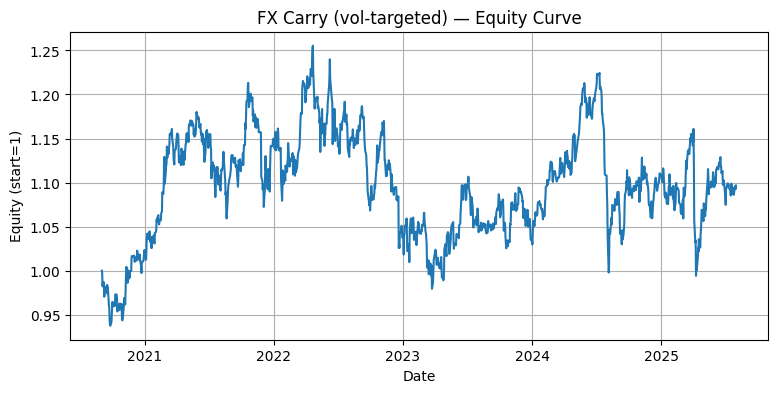

Parameter values: top_n = 2 | bottom_n = 2 | trans_cost = 1.0 | target_vol = 0.3 | vol_window = 60 | min/max leverage = 0.2 / 2.0


ann_return    0.0295
ann_vol       0.1508
sharpe        0.1959
max_dd       -0.2198
Name: fx_carry_voltarget, dtype: float64

In [446]:
#Belo we call sum() twice on the 2D objects and once on the 1D object
print("NaN — returns:", returns.isna().sum().sum(), "| weights_vt:", weights_vt.isna().sum().sum(), "| net:", net.isna().sum())

# equity curve plot
import matplotlib.pyplot as plt
plt.figure(figsize=(9,4))
plt.plot(equity.index, equity.values)
plt.title("FX Carry (vol-targeted) — Equity Curve")
plt.xlabel("Date"); plt.ylabel("Equity (start=1)")
plt.grid(True)
plt.show()
print("Parameter values: top_n =", top_n, "| bottom_n =", bottom_n, "| trans_cost =", trans_cost, "| target_vol =", target_vol, "| vol_window =", vol_window,
      "| min/max leverage =",lev_min, "/",lev_max)
display(metrics)

### Evaluation
We can see that the vol target (10%) is being achieved, which is good. Our strategy starts strong, but starts going sideways around 2022, and eventually declines. Ie our carry signal is no longer profitable after around 2022.

#### Explanation:
* 2020-2021: steadily going up, this is due to FX carry excelling in low rate/stable USD time frames.
* 2022-PResent: The Fed began a hiking cycle. As I am long high rate currencies and short low rate onces, once USD rates shot up, my algo started shorting USD crosses. Around this time general risk sentiment was poor, and funding currencies (money borrowed in one currency to purchase another) such as CHF shot up (against the dollar). As is widely known, when vol spikes, carry strategies tend to go bust as our high yeild currencies we are longing tend to fall and the usual "safe haven" currencies (eg CHF) increase. This causes the PnL of the strategy to take a hit. See the graph below for plots of CHF against the dollar
* Even small transcation costs erode already slim FX spreads. This erodes SHarpe ratio and decreases the viability of the strategy.

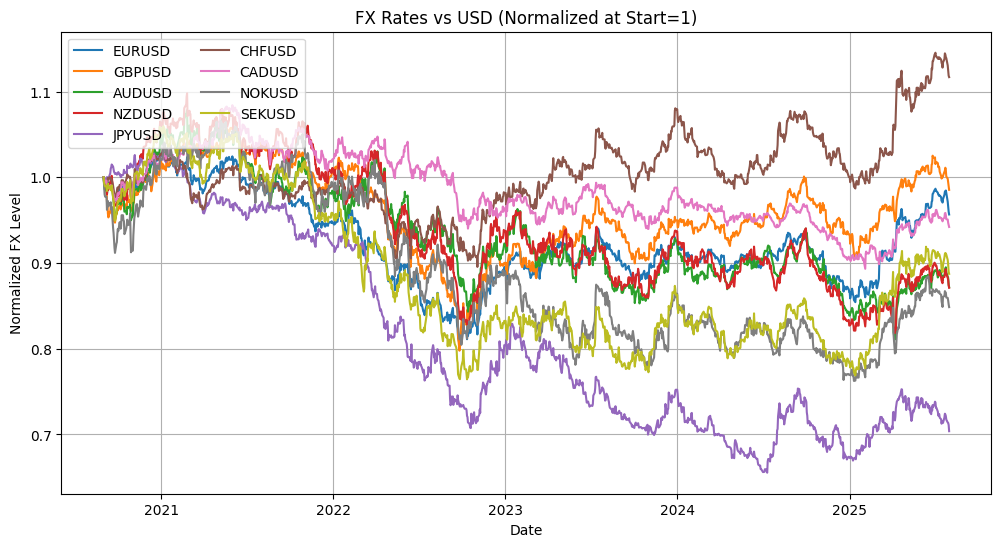

In [447]:
fx_norm = fx / fx.iloc[0]  #normalise to 1.0

plt.figure(figsize=(12,6))
for col in fx_norm.columns:
    plt.plot(fx_norm.index, fx_norm[col], label=col)

plt.title("FX Rates vs USD (Normalized at Start=1)")
plt.xlabel("Date")
plt.ylabel("Normalized FX Level")
plt.legend(loc="upper left", ncol=2)
plt.grid(True)
plt.show()